<div class="alert alert-block alert-success">

# Plaut Model > plaut_model

### Purpose
Implement the Plaut Model

### Date Created
November 11, 2019
***
#### Revisions
 - For revisions after Jan 02, 2020: refer to the .py files in the same folder
 - Jan 02, 2020: Happy New Year! Multiple revisions, see below:
     * Minor bug fixes to folder creation in training
     * Migrate model architecture to model.py
     * Migrate code to import data to simulator.py
     * Migrate code to make folder for storing simulation results to helpers.py
     * Migrate training code to simulator.py
 - Dec 30, 2019: Update filepaths in code to match new file organization
 - Nov 28, 2019: Update training epochs to 500+100, add training for anchors
 - Nov 27, 2019: Move dataset class, helper functions to separate files, Add plotting for accuracy for plaut dataset, anchors and probes
 - Nov 25, 2019: Update get_accuracy function to correspond to sigmoid activated output, Lower print/plot frequency
 - Nov 24, 2019: Replace BCEWithLogitsLoss with BCELoss, and added sigmoid activation to model output
 - Nov 21, 2019: Include correct frequency, fixes to dataset structure
 - Nov 14, 2019: Updates to include frequency
 - Nov 11, 2019: Create file, implement initial Plaut model and train

</div>

### Code to Run Simulation

Test Results will be stored in:  /Users/BrianLam/UTSC Research/Plaut_Model/results/jan08_test07
[EPOCH 1] 	 loss: 0.686796 	 time: 0.6009 
[EPOCH 2] 	 loss: 0.686793 	 time: 0.5881 
[EPOCH 3] 	 loss: 0.686790 	 time: 0.6277 
[EPOCH 4] 	 loss: 0.686787 	 time: 0.5982 
[EPOCH 5] 	 loss: 0.686784 	 time: 0.5933 
[EPOCH 6] 	 loss: 0.686781 	 time: 0.5893 
[EPOCH 7] 	 loss: 0.686778 	 time: 0.6201 
[EPOCH 8] 	 loss: 0.686776 	 time: 0.5757 
[EPOCH 9] 	 loss: 0.686773 	 time: 0.6197 
[EPOCH 10] 	 loss: 0.686770 	 time: 0.5902 
[EPOCH 11] 	 loss: 0.686767 	 time: 0.5950 
[EPOCH 12] 	 loss: 0.656135 	 time: 0.5981 
[EPOCH 13] 	 loss: 0.631232 	 time: 0.5904 
[EPOCH 14] 	 loss: 0.610739 	 time: 0.6878 
[EPOCH 15] 	 loss: 0.593898 	 time: 0.6438 
[EPOCH 16] 	 loss: 0.580211 	 time: 0.6847 
[EPOCH 17] 	 loss: 0.569262 	 time: 0.6328 
[EPOCH 18] 	 loss: 0.560655 	 time: 0.6646 
[EPOCH 19] 	 loss: 0.553999 	 time: 0.6288 
[EPOCH 20] 	 loss: 0.548887 	 time: 0.6484 
[EPOCH 21] 	 loss: 0.544909 	 tim

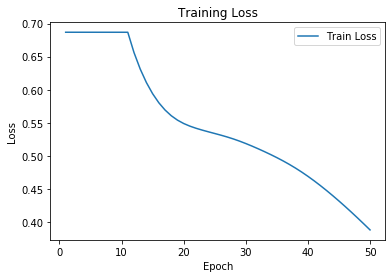

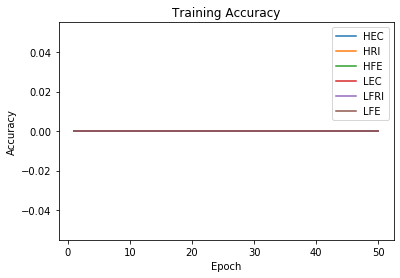

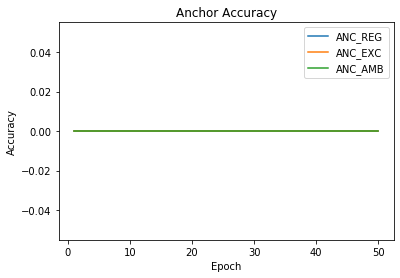

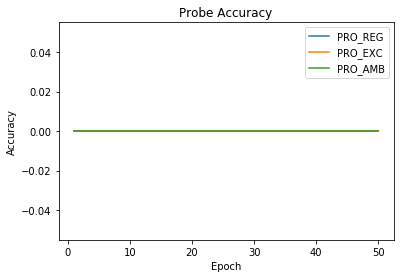

[EPOCH 51] 	 loss: 0.378909 	 time: 0.6482 
[EPOCH 52] 	 loss: 0.369614 	 time: 0.5777 
[EPOCH 53] 	 loss: 0.360263 	 time: 0.6308 
[EPOCH 54] 	 loss: 0.350899 	 time: 0.5834 
[EPOCH 55] 	 loss: 0.341574 	 time: 0.6252 
[EPOCH 56] 	 loss: 0.332340 	 time: 0.5680 
[EPOCH 57] 	 loss: 0.323242 	 time: 0.5780 
[EPOCH 58] 	 loss: 0.314308 	 time: 0.6028 
[EPOCH 59] 	 loss: 0.305545 	 time: 0.5766 
[EPOCH 60] 	 loss: 0.296953 	 time: 0.6042 
[EPOCH 61] 	 loss: 0.288532 	 time: 0.5793 
[EPOCH 62] 	 loss: 0.280290 	 time: 0.6090 
[EPOCH 63] 	 loss: 0.272248 	 time: 0.5703 
[EPOCH 64] 	 loss: 0.264429 	 time: 0.6092 
[EPOCH 65] 	 loss: 0.256852 	 time: 0.5787 
[EPOCH 66] 	 loss: 0.249519 	 time: 0.5924 
[EPOCH 67] 	 loss: 0.242428 	 time: 0.5948 
[EPOCH 68] 	 loss: 0.235574 	 time: 0.5753 
[EPOCH 69] 	 loss: 0.228955 	 time: 0.6084 
[EPOCH 70] 	 loss: 0.222573 	 time: 0.5770 
[EPOCH 71] 	 loss: 0.216431 	 time: 0.6200 
[EPOCH 72] 	 loss: 0.210530 	 time: 0.5889 
[EPOCH 73] 	 loss: 0.204864 	 ti

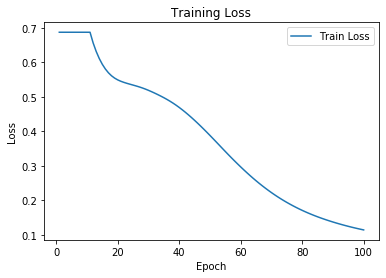

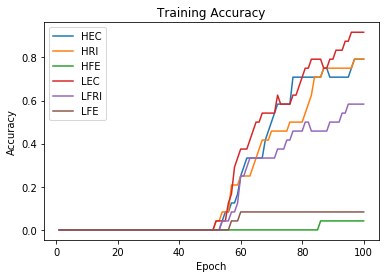

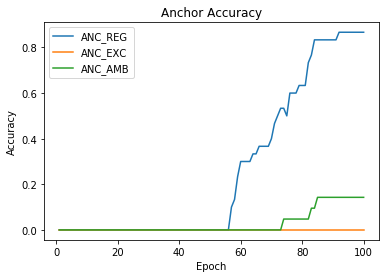

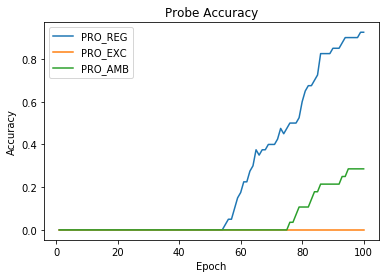

[EPOCH 101] 	 loss: 0.112646 	 time: 0.5865 
[EPOCH 102] 	 loss: 0.110852 	 time: 0.5936 
[EPOCH 103] 	 loss: 0.109119 	 time: 0.5807 
[EPOCH 104] 	 loss: 0.107442 	 time: 0.6162 
[EPOCH 105] 	 loss: 0.105819 	 time: 0.5707 
[EPOCH 106] 	 loss: 0.104249 	 time: 0.6084 
[EPOCH 107] 	 loss: 0.102729 	 time: 0.5811 
[EPOCH 108] 	 loss: 0.101259 	 time: 0.6241 
[EPOCH 109] 	 loss: 0.099835 	 time: 0.5810 
[EPOCH 110] 	 loss: 0.098457 	 time: 0.5793 
[EPOCH 111] 	 loss: 0.097123 	 time: 0.6050 
[EPOCH 112] 	 loss: 0.095829 	 time: 0.5662 
[EPOCH 113] 	 loss: 0.094576 	 time: 0.6115 
[EPOCH 114] 	 loss: 0.093361 	 time: 0.6009 
[EPOCH 115] 	 loss: 0.092183 	 time: 0.6658 
[EPOCH 116] 	 loss: 0.091039 	 time: 0.5765 
[EPOCH 117] 	 loss: 0.089928 	 time: 0.6142 
[EPOCH 118] 	 loss: 0.088850 	 time: 0.5752 
[EPOCH 119] 	 loss: 0.087802 	 time: 0.5725 
[EPOCH 120] 	 loss: 0.086784 	 time: 0.6198 
[EPOCH 121] 	 loss: 0.085794 	 time: 0.5730 
[EPOCH 122] 	 loss: 0.084833 	 time: 0.6110 
[EPOCH 123

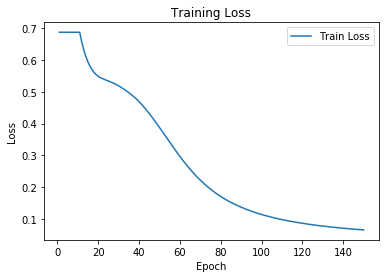

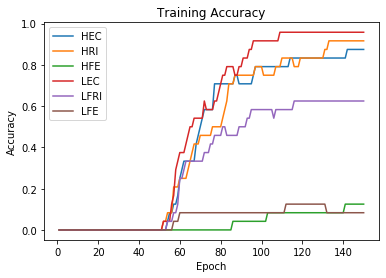

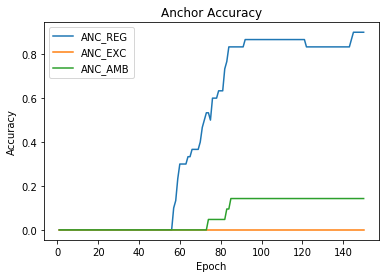

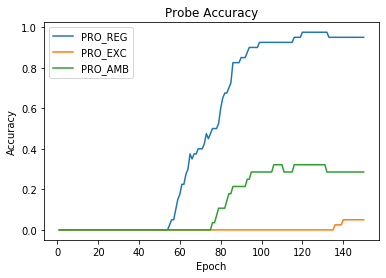

[EPOCH 151] 	 loss: 0.065550 	 time: 0.5807 
[EPOCH 152] 	 loss: 0.065090 	 time: 0.5676 
[EPOCH 153] 	 loss: 0.064639 	 time: 0.5906 
[EPOCH 154] 	 loss: 0.064197 	 time: 0.5813 
[EPOCH 155] 	 loss: 0.063764 	 time: 0.5887 
[EPOCH 156] 	 loss: 0.063338 	 time: 0.5697 
[EPOCH 157] 	 loss: 0.062921 	 time: 0.6660 
[EPOCH 158] 	 loss: 0.062511 	 time: 0.6285 
[EPOCH 159] 	 loss: 0.062108 	 time: 0.6412 
[EPOCH 160] 	 loss: 0.061713 	 time: 0.5838 
[EPOCH 161] 	 loss: 0.061324 	 time: 0.5883 
[EPOCH 162] 	 loss: 0.060942 	 time: 0.5920 
[EPOCH 163] 	 loss: 0.060566 	 time: 0.5859 
[EPOCH 164] 	 loss: 0.060197 	 time: 0.6579 
[EPOCH 165] 	 loss: 0.059833 	 time: 0.5810 
[EPOCH 166] 	 loss: 0.059475 	 time: 0.6427 
[EPOCH 167] 	 loss: 0.059123 	 time: 0.5900 
[EPOCH 168] 	 loss: 0.058776 	 time: 0.6200 
[EPOCH 169] 	 loss: 0.058434 	 time: 0.5751 
[EPOCH 170] 	 loss: 0.058098 	 time: 0.6153 
[EPOCH 171] 	 loss: 0.057766 	 time: 0.5889 
[EPOCH 172] 	 loss: 0.057439 	 time: 0.5777 
[EPOCH 173

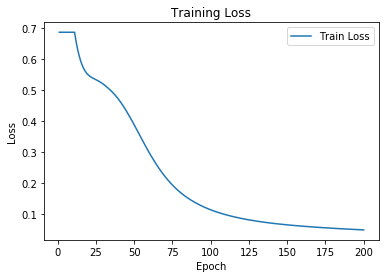

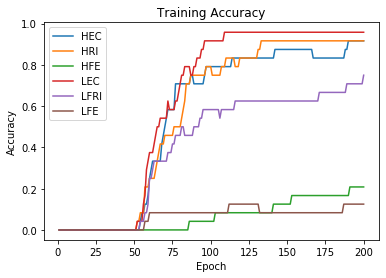

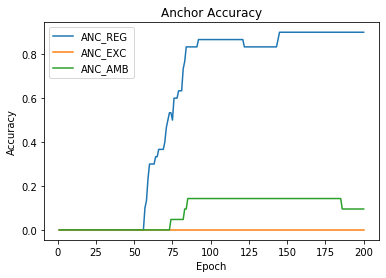

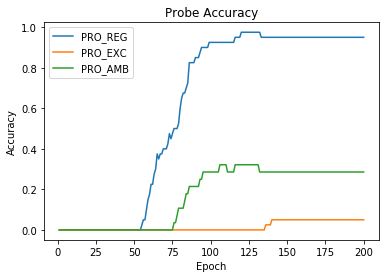

[EPOCH 201] 	 loss: 0.049495 	 time: 0.6224 
[EPOCH 202] 	 loss: 0.049261 	 time: 0.5910 
[EPOCH 203] 	 loss: 0.049029 	 time: 0.6074 
[EPOCH 204] 	 loss: 0.048799 	 time: 0.5904 
[EPOCH 205] 	 loss: 0.048572 	 time: 0.5822 
[EPOCH 206] 	 loss: 0.048346 	 time: 0.5906 
[EPOCH 207] 	 loss: 0.048122 	 time: 0.6783 
[EPOCH 208] 	 loss: 0.047899 	 time: 0.6007 
[EPOCH 209] 	 loss: 0.047679 	 time: 0.5887 
[EPOCH 210] 	 loss: 0.047461 	 time: 0.6286 
[EPOCH 211] 	 loss: 0.047244 	 time: 0.5863 
[EPOCH 212] 	 loss: 0.047028 	 time: 0.6096 
[EPOCH 213] 	 loss: 0.046815 	 time: 0.5661 
[EPOCH 214] 	 loss: 0.046603 	 time: 0.5947 
[EPOCH 215] 	 loss: 0.046393 	 time: 0.6026 
[EPOCH 216] 	 loss: 0.046184 	 time: 0.5722 
[EPOCH 217] 	 loss: 0.045977 	 time: 0.6127 
[EPOCH 218] 	 loss: 0.045772 	 time: 0.5782 
[EPOCH 219] 	 loss: 0.045567 	 time: 0.5944 
[EPOCH 220] 	 loss: 0.045365 	 time: 0.5752 
[EPOCH 221] 	 loss: 0.045164 	 time: 0.6120 
[EPOCH 222] 	 loss: 0.044964 	 time: 0.5799 
[EPOCH 223

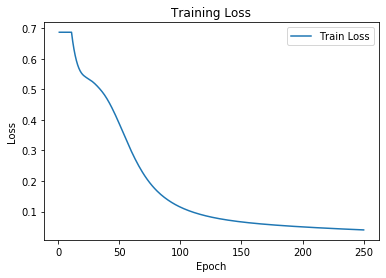

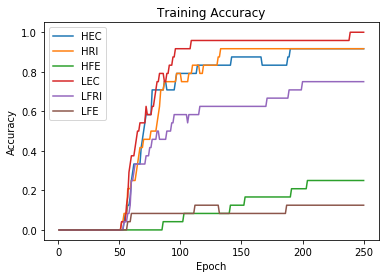

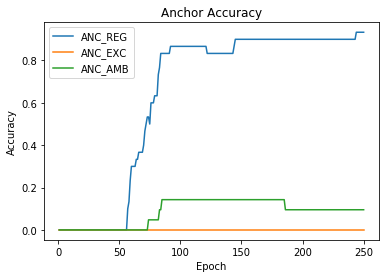

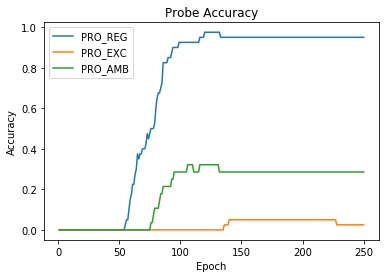

[EPOCH 251] 	 loss: 0.039696 	 time: 0.5797 
[EPOCH 252] 	 loss: 0.039529 	 time: 0.6077 
[EPOCH 253] 	 loss: 0.039364 	 time: 0.5718 
[EPOCH 254] 	 loss: 0.039200 	 time: 0.6019 
[EPOCH 255] 	 loss: 0.039036 	 time: 0.5841 
[EPOCH 256] 	 loss: 0.038874 	 time: 0.6171 
[EPOCH 257] 	 loss: 0.038712 	 time: 0.6958 
[EPOCH 258] 	 loss: 0.038551 	 time: 0.5864 
[EPOCH 259] 	 loss: 0.038391 	 time: 0.5914 
[EPOCH 260] 	 loss: 0.038232 	 time: 0.5599 
[EPOCH 261] 	 loss: 0.038073 	 time: 0.6041 
[EPOCH 262] 	 loss: 0.037915 	 time: 0.5865 
[EPOCH 263] 	 loss: 0.037759 	 time: 0.6149 
[EPOCH 264] 	 loss: 0.037602 	 time: 0.6655 
[EPOCH 265] 	 loss: 0.037447 	 time: 0.7986 
[EPOCH 266] 	 loss: 0.037293 	 time: 0.7264 
[EPOCH 267] 	 loss: 0.037139 	 time: 0.8750 
[EPOCH 268] 	 loss: 0.036986 	 time: 0.7563 
[EPOCH 269] 	 loss: 0.036834 	 time: 0.8057 
[EPOCH 270] 	 loss: 0.036682 	 time: 0.6496 
[EPOCH 271] 	 loss: 0.036531 	 time: 0.8025 
[EPOCH 272] 	 loss: 0.036381 	 time: 0.7560 
[EPOCH 273

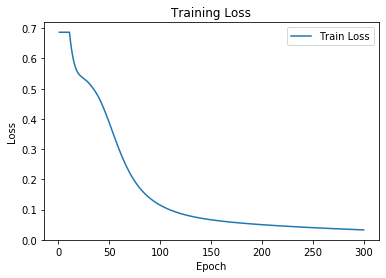

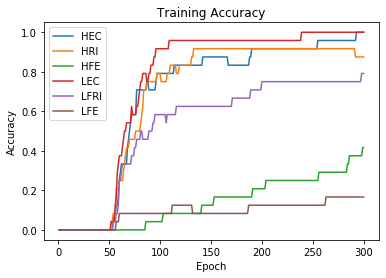

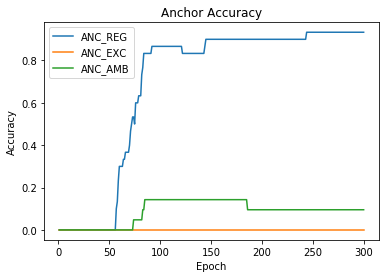

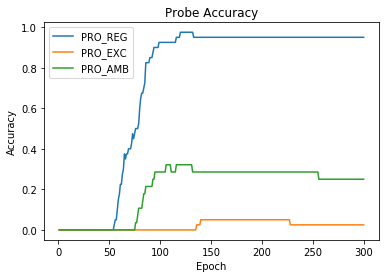

[EPOCH 301] 	 loss: 0.032328 	 time: 0.9534 
[EPOCH 302] 	 loss: 0.032198 	 time: 0.7261 
[EPOCH 303] 	 loss: 0.032068 	 time: 0.9359 
[EPOCH 304] 	 loss: 0.031939 	 time: 0.7902 
[EPOCH 305] 	 loss: 0.031810 	 time: 0.8319 
[EPOCH 306] 	 loss: 0.031683 	 time: 0.7522 
[EPOCH 307] 	 loss: 0.031555 	 time: 0.6718 
[EPOCH 308] 	 loss: 0.031429 	 time: 0.5923 
[EPOCH 309] 	 loss: 0.031302 	 time: 0.6908 
[EPOCH 310] 	 loss: 0.031177 	 time: 0.6941 
[EPOCH 311] 	 loss: 0.031052 	 time: 0.6016 
[EPOCH 312] 	 loss: 0.030927 	 time: 0.7097 
[EPOCH 313] 	 loss: 0.030804 	 time: 0.6202 
[EPOCH 314] 	 loss: 0.030680 	 time: 0.6388 
[EPOCH 315] 	 loss: 0.030558 	 time: 0.6032 
[EPOCH 316] 	 loss: 0.030435 	 time: 0.8650 
[EPOCH 317] 	 loss: 0.030314 	 time: 0.5752 
[EPOCH 318] 	 loss: 0.030193 	 time: 0.5738 
[EPOCH 319] 	 loss: 0.030072 	 time: 0.6015 
[EPOCH 320] 	 loss: 0.029952 	 time: 0.5848 
[EPOCH 321] 	 loss: 0.029833 	 time: 0.6372 
[EPOCH 322] 	 loss: 0.029714 	 time: 0.6369 
[EPOCH 323

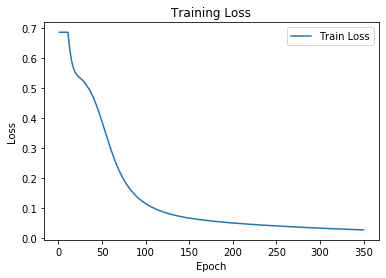

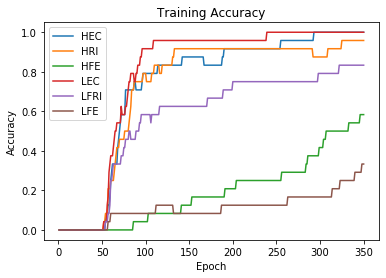

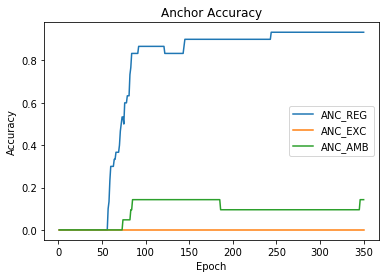

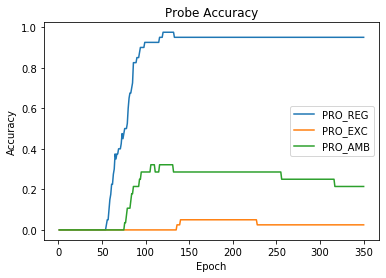

[EPOCH 351] 	 loss: 0.026489 	 time: 0.5918 
[EPOCH 352] 	 loss: 0.026386 	 time: 0.7601 
[EPOCH 353] 	 loss: 0.026282 	 time: 0.5637 
[EPOCH 354] 	 loss: 0.026179 	 time: 0.6311 
[EPOCH 355] 	 loss: 0.026077 	 time: 0.5738 
[EPOCH 356] 	 loss: 0.025975 	 time: 0.5989 
[EPOCH 357] 	 loss: 0.025873 	 time: 0.6409 
[EPOCH 358] 	 loss: 0.025772 	 time: 0.6812 
[EPOCH 359] 	 loss: 0.025671 	 time: 0.6108 
[EPOCH 360] 	 loss: 0.025571 	 time: 0.6232 
[EPOCH 361] 	 loss: 0.025471 	 time: 0.5603 
[EPOCH 362] 	 loss: 0.025372 	 time: 0.5868 
[EPOCH 363] 	 loss: 0.025273 	 time: 0.6318 
[EPOCH 364] 	 loss: 0.025175 	 time: 0.5816 
[EPOCH 365] 	 loss: 0.025077 	 time: 0.6160 
[EPOCH 366] 	 loss: 0.024979 	 time: 0.5767 
[EPOCH 367] 	 loss: 0.024882 	 time: 0.5954 
[EPOCH 368] 	 loss: 0.024786 	 time: 0.5942 
[EPOCH 369] 	 loss: 0.024689 	 time: 0.6832 
[EPOCH 370] 	 loss: 0.024594 	 time: 0.6228 
[EPOCH 371] 	 loss: 0.024498 	 time: 0.5879 
[EPOCH 372] 	 loss: 0.024403 	 time: 0.5893 
[EPOCH 373

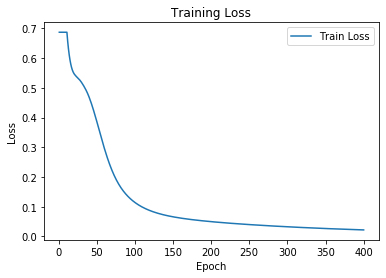

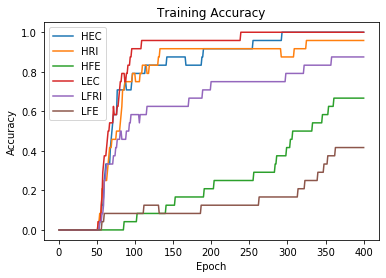

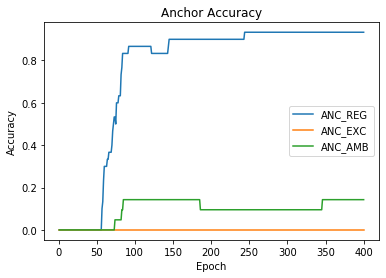

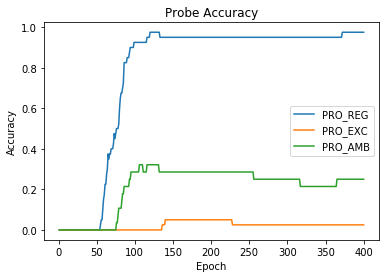

[EPOCH 401] 	 loss: 0.021830 	 time: 0.5773 
[EPOCH 402] 	 loss: 0.021747 	 time: 0.7183 
[EPOCH 403] 	 loss: 0.021664 	 time: 0.5826 
[EPOCH 404] 	 loss: 0.021582 	 time: 0.5710 
[EPOCH 405] 	 loss: 0.021500 	 time: 0.6025 
[EPOCH 406] 	 loss: 0.021419 	 time: 0.5876 
[EPOCH 407] 	 loss: 0.021338 	 time: 0.6020 
[EPOCH 408] 	 loss: 0.021257 	 time: 0.5625 
[EPOCH 409] 	 loss: 0.021177 	 time: 0.5983 
[EPOCH 410] 	 loss: 0.021097 	 time: 0.5967 
[EPOCH 411] 	 loss: 0.021018 	 time: 0.6164 
[EPOCH 412] 	 loss: 0.020939 	 time: 0.7197 
[EPOCH 413] 	 loss: 0.020860 	 time: 0.9005 
[EPOCH 414] 	 loss: 0.020781 	 time: 0.8214 
[EPOCH 415] 	 loss: 0.020703 	 time: 1.1124 
[EPOCH 416] 	 loss: 0.020625 	 time: 1.3393 
[EPOCH 417] 	 loss: 0.020548 	 time: 2.0416 
[EPOCH 418] 	 loss: 0.020471 	 time: 2.7541 
[EPOCH 419] 	 loss: 0.020394 	 time: 2.1725 
[EPOCH 420] 	 loss: 0.020318 	 time: 3.0132 
[EPOCH 421] 	 loss: 0.020242 	 time: 1.5547 
[EPOCH 422] 	 loss: 0.020166 	 time: 1.6391 
[EPOCH 423

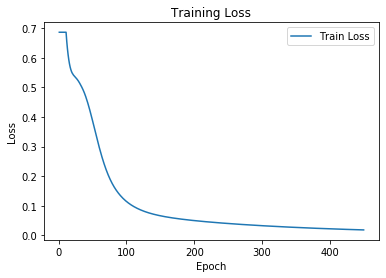

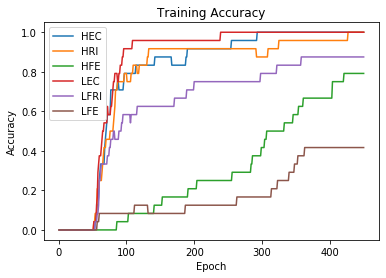

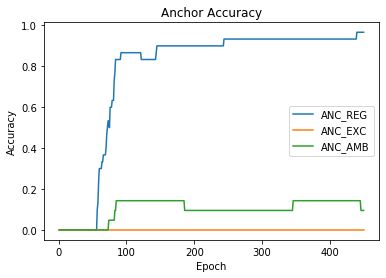

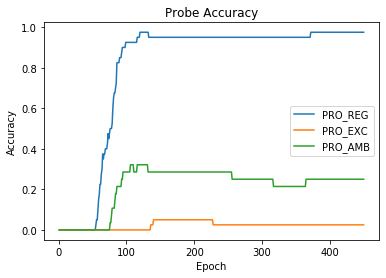

[EPOCH 451] 	 loss: 0.018115 	 time: 0.6289 
[EPOCH 452] 	 loss: 0.018049 	 time: 0.5954 
[EPOCH 453] 	 loss: 0.017984 	 time: 0.5985 
[EPOCH 454] 	 loss: 0.017918 	 time: 0.5878 
[EPOCH 455] 	 loss: 0.017853 	 time: 0.6123 
[EPOCH 456] 	 loss: 0.017789 	 time: 0.6274 
[EPOCH 457] 	 loss: 0.017724 	 time: 0.6518 
[EPOCH 458] 	 loss: 0.017660 	 time: 0.5894 
[EPOCH 459] 	 loss: 0.017596 	 time: 0.5657 
[EPOCH 460] 	 loss: 0.017532 	 time: 0.6099 
[EPOCH 461] 	 loss: 0.017469 	 time: 0.5874 
[EPOCH 462] 	 loss: 0.017406 	 time: 0.6153 
[EPOCH 463] 	 loss: 0.017343 	 time: 0.5739 
[EPOCH 464] 	 loss: 0.017281 	 time: 0.6072 
[EPOCH 465] 	 loss: 0.017219 	 time: 0.5757 
[EPOCH 466] 	 loss: 0.017157 	 time: 0.5750 
[EPOCH 467] 	 loss: 0.017095 	 time: 0.5906 
[EPOCH 468] 	 loss: 0.017034 	 time: 0.5820 
[EPOCH 469] 	 loss: 0.016973 	 time: 0.6128 
[EPOCH 470] 	 loss: 0.016912 	 time: 0.5868 
[EPOCH 471] 	 loss: 0.016852 	 time: 0.6277 
[EPOCH 472] 	 loss: 0.016792 	 time: 0.5671 
[EPOCH 473

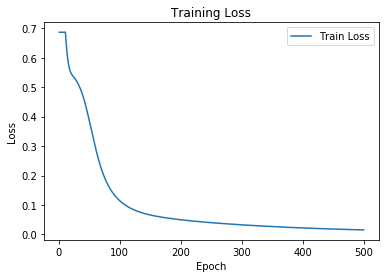

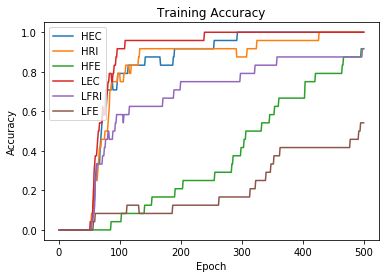

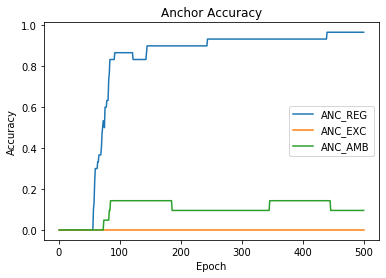

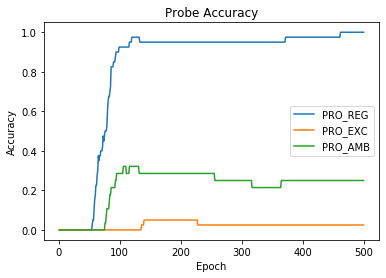

[EPOCH 501] 	 loss: 0.008279 	 time: 0.8354 
[EPOCH 502] 	 loss: 0.008239 	 time: 0.9369 
[EPOCH 503] 	 loss: 0.008173 	 time: 0.6967 
[EPOCH 504] 	 loss: 0.008091 	 time: 0.6705 
[EPOCH 505] 	 loss: 0.007999 	 time: 0.6391 
[EPOCH 506] 	 loss: 0.007901 	 time: 0.7741 
[EPOCH 507] 	 loss: 0.007802 	 time: 0.7698 
[EPOCH 508] 	 loss: 0.007703 	 time: 0.7719 
[EPOCH 509] 	 loss: 0.007604 	 time: 0.6050 
[EPOCH 510] 	 loss: 0.007505 	 time: 0.6610 
[EPOCH 511] 	 loss: 0.007405 	 time: 0.6834 
[EPOCH 512] 	 loss: 0.007304 	 time: 0.6171 
[EPOCH 513] 	 loss: 0.007203 	 time: 0.6066 
[EPOCH 514] 	 loss: 0.007105 	 time: 0.6580 
[EPOCH 515] 	 loss: 0.007009 	 time: 0.6034 
[EPOCH 516] 	 loss: 0.006918 	 time: 0.5882 
[EPOCH 517] 	 loss: 0.006833 	 time: 0.6125 
[EPOCH 518] 	 loss: 0.006752 	 time: 0.5726 
[EPOCH 519] 	 loss: 0.006677 	 time: 0.5739 
[EPOCH 520] 	 loss: 0.006607 	 time: 0.6092 
[EPOCH 521] 	 loss: 0.006540 	 time: 0.5566 
[EPOCH 522] 	 loss: 0.006478 	 time: 0.6035 
[EPOCH 523

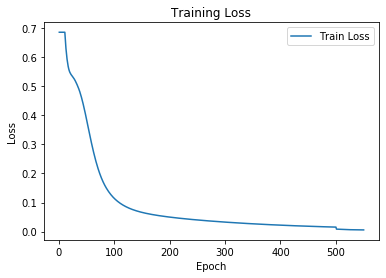

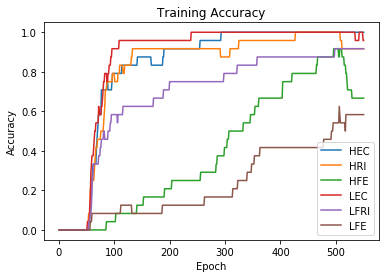

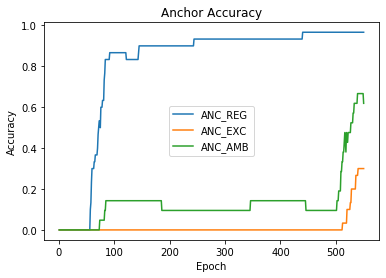

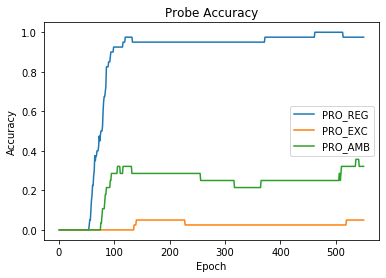

[EPOCH 551] 	 loss: 0.005536 	 time: 0.5765 
[EPOCH 552] 	 loss: 0.005518 	 time: 0.5927 
[EPOCH 553] 	 loss: 0.005500 	 time: 0.5973 
[EPOCH 554] 	 loss: 0.005483 	 time: 0.5862 
[EPOCH 555] 	 loss: 0.005466 	 time: 0.6032 
[EPOCH 556] 	 loss: 0.005449 	 time: 0.5931 
[EPOCH 557] 	 loss: 0.005433 	 time: 0.6166 
[EPOCH 558] 	 loss: 0.005417 	 time: 0.6638 
[EPOCH 559] 	 loss: 0.005401 	 time: 0.6670 
[EPOCH 560] 	 loss: 0.005385 	 time: 0.5634 
[EPOCH 561] 	 loss: 0.005370 	 time: 0.6256 
[EPOCH 562] 	 loss: 0.005355 	 time: 0.5890 
[EPOCH 563] 	 loss: 0.005341 	 time: 0.5742 
[EPOCH 564] 	 loss: 0.005326 	 time: 0.6227 
[EPOCH 565] 	 loss: 0.005312 	 time: 0.5932 
[EPOCH 566] 	 loss: 0.005298 	 time: 0.6183 
[EPOCH 567] 	 loss: 0.005285 	 time: 0.5831 
[EPOCH 568] 	 loss: 0.005271 	 time: 0.6140 
[EPOCH 569] 	 loss: 0.005258 	 time: 0.5858 
[EPOCH 570] 	 loss: 0.005245 	 time: 0.6048 
[EPOCH 571] 	 loss: 0.005232 	 time: 0.5787 
[EPOCH 572] 	 loss: 0.005219 	 time: 0.5962 
[EPOCH 573

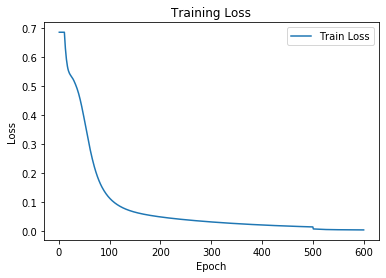

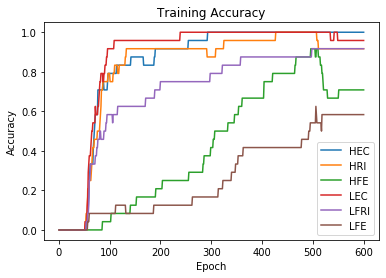

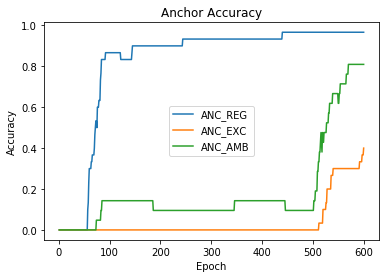

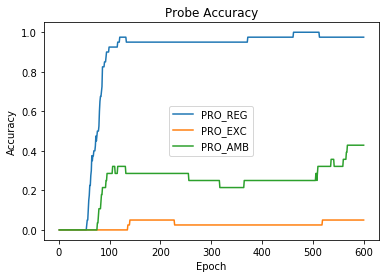

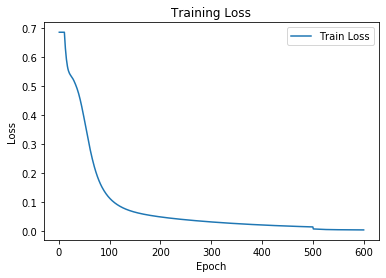

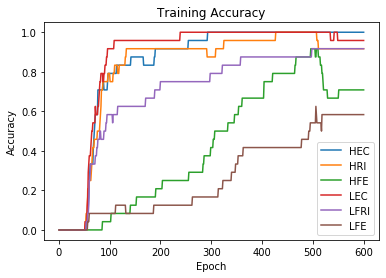

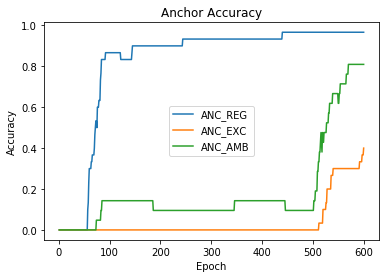

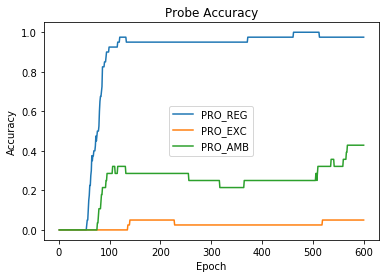

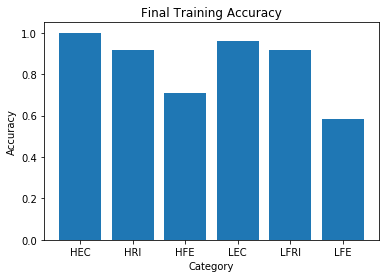

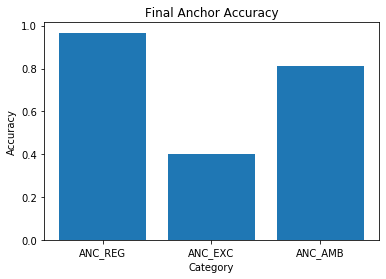

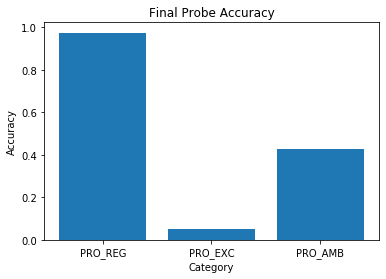

Training Completed!
Add any notes below to save with results:
 > 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from simulator import *
sim = simulator()
sim.train()

In [7]:
print(sim.plaut_ds[0])
print(sim.plaut_anc_ds[0])

{'type': '#', 'orth': 'ace', 'phon': '/As/', 'frequency': tensor(2.8332), 'graphemes': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'phonemes': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])}
{'type': '#', 'orth': 'ace', 'phon': '/As/', 'frequency': tensor(0.6931), 'graphemes': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Training Function (old)

In [4]:
def train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, folder, lr=0.001):
    # define loss function and optimizer
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize arrays to store epochs, train loss
    epochs, losses = [], []
    
    # Select word types to calculate accuracy for
    types = ["HEC", "HRI", "HFE", "LEC", "LFRI", "LFEEXPT"] # calculate accuracy of these types
    anc_types = ["ANC_REG", "ANC_EXC", "ANC_AMB"]
    probe_types = ["PRO_REG", "PRO_EXC", "PRO_AMB"]
    
    # Initialize arrays to store accuracy of plaut dataset, anchors, probes
    acc = [[], [], [], []]
    anc_acc = [[] for i in anc_types]
    probe_acc = [[] for i in probe_types]
    
    for epoch in range(600):
        if epoch < 500: # use only plaut dataset for first 500 epochs
            data_loader = plaut_loader
        else: # after, train with both plaut + anchors
            data_loader = plaut_anc_loader
        
        avg_loss = 0 # initialize avg loss
        for i, data in enumerate(data_loader): 
            # extract frequency, inputs, labels
            freq = data["frequency"].float().view(-1, 1) # reshape to [batch_size x 1] to match output size
            inputs = data["graphemes"].float()
            labels = data["phonemes"].float()
            
            #forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = (loss*freq).mean() # scale loss by frequency, then find mean
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # calculate loss and save loss to array
        losses.append(avg_loss)
        epochs.append(epoch+1)
        
        # calculate accuracy over the different types for plaut dataset
        temp_acc = get_accuracy(model, plaut_loader, types)
        acc[0].append((temp_acc[0]+temp_acc[1])/2) # average of HFR consistent and inconsistent
        acc[1].append(temp_acc[2]) # HFE
        acc[2].append((temp_acc[3]+temp_acc[4])/2) # average of LFR consistent and inconsistent
        acc[3].append(temp_acc[5]) # LFE
        
        # calculate accuracy over the different types for anchors
        temp_acc = get_accuracy(model, anc_loader, anc_types, vowels_only=True)
        for i in range(len(anc_types)):
            anc_acc[i].append(temp_acc[i])
            
        # calculate accuracy over the different types for probes
        temp_acc = get_accuracy(model, probe_loader, probe_types, vowels_only=True)
        for i in range(len(probe_types)):
            probe_acc[i].append(temp_acc[i])
        
        # print stats every 5 epochs
        if epoch % 1 == 0:
            print("[EPOCH %d] loss: %.6f" % (epoch+1, avg_loss))
        
        # plot loss every 5 epochs
        if epoch % 50 == 49:
            make_plot(epochs, [losses], ["Train Loss"], "Epoch", "Loss", "Training Loss")
            make_plot(epochs, acc, ["HFR", "HFE", "LFR", "LFE"], "Epoch", "Accuracy", "Training Accuracy")
            make_plot(epochs, anc_acc, anc_types, "Epoch", "Accuracy", "Anchor Accuracy")
            make_plot(epochs, probe_acc, probe_types, "Epoch", "Accuracy", "Probe Accuracy")
            

    # plot final loss curve and save
    plt.figure()
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(losses, label="Training Loss")
    plt.savefig(rootdir+"/lossplot_final.png", dpi=150)
    plt.close()

### Training

Test Results saved in : /Users/BrianLam/UTSC Research/Plaut_Model/results/jan01_test01
[EPOCH 1] loss: 2.005025
[EPOCH 2] loss: 0.761653
[EPOCH 3] loss: 0.916140
[EPOCH 4] loss: 0.833535
[EPOCH 5] loss: 0.683057
[EPOCH 6] loss: 0.583609
[EPOCH 7] loss: 0.580636
[EPOCH 8] loss: 0.625002
[EPOCH 9] loss: 0.653815
[EPOCH 10] loss: 0.647629
[EPOCH 11] loss: 0.615382
[EPOCH 12] loss: 0.576462
[EPOCH 13] loss: 0.549712
[EPOCH 14] loss: 0.544086
[EPOCH 15] loss: 0.554972
[EPOCH 16] loss: 0.569968
[EPOCH 17] loss: 0.578402
[EPOCH 18] loss: 0.576153
[EPOCH 19] loss: 0.565118
[EPOCH 20] loss: 0.550576
[EPOCH 21] loss: 0.538279
[EPOCH 22] loss: 0.531908
[EPOCH 23] loss: 0.531679
[EPOCH 24] loss: 0.534836
[EPOCH 25] loss: 0.537646
[EPOCH 26] loss: 0.537471
[EPOCH 27] loss: 0.533734
[EPOCH 28] loss: 0.527637
[EPOCH 29] loss: 0.521171
[EPOCH 30] loss: 0.516019
[EPOCH 31] loss: 0.512850
[EPOCH 32] loss: 0.511229
[EPOCH 33] loss: 0.510051
[EPOCH 34] loss: 0.508133
[EPOCH 35] loss: 0.504707
[EPOCH 36] l

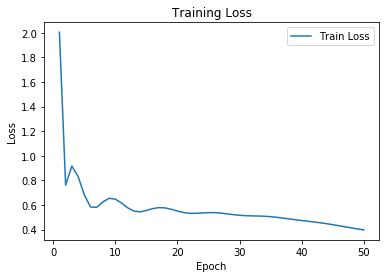

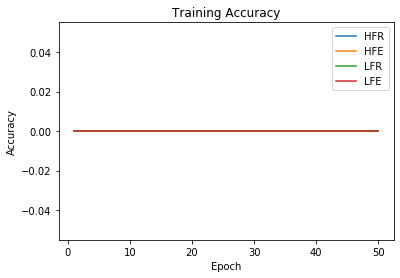

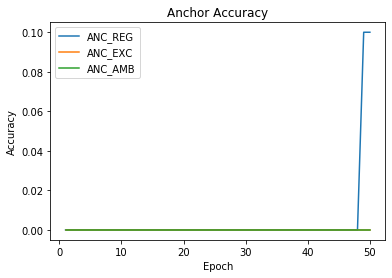

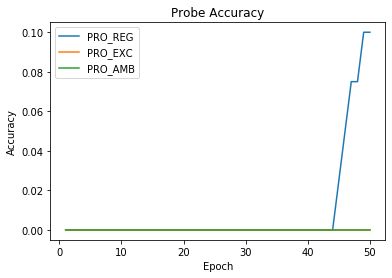

[EPOCH 51] loss: 0.388859
[EPOCH 52] loss: 0.380561
[EPOCH 53] loss: 0.372071
[EPOCH 54] loss: 0.363506
[EPOCH 55] loss: 0.355042
[EPOCH 56] loss: 0.346820
[EPOCH 57] loss: 0.338873
[EPOCH 58] loss: 0.331135
[EPOCH 59] loss: 0.323494
[EPOCH 60] loss: 0.315871
[EPOCH 61] loss: 0.308264
[EPOCH 62] loss: 0.300742
[EPOCH 63] loss: 0.293401
[EPOCH 64] loss: 0.286312
[EPOCH 65] loss: 0.279488
[EPOCH 66] loss: 0.272896
[EPOCH 67] loss: 0.266485
[EPOCH 68] loss: 0.260224
[EPOCH 69] loss: 0.254114
[EPOCH 70] loss: 0.248185
[EPOCH 71] loss: 0.242469
[EPOCH 72] loss: 0.236978
[EPOCH 73] loss: 0.231697
[EPOCH 74] loss: 0.226594
[EPOCH 75] loss: 0.221639
[EPOCH 76] loss: 0.216818
[EPOCH 77] loss: 0.212134
[EPOCH 78] loss: 0.207601
[EPOCH 79] loss: 0.203226
[EPOCH 80] loss: 0.199004
[EPOCH 81] loss: 0.194921
[EPOCH 82] loss: 0.190963
[EPOCH 83] loss: 0.187119
[EPOCH 84] loss: 0.183389
[EPOCH 85] loss: 0.179774
[EPOCH 86] loss: 0.176277
[EPOCH 87] loss: 0.172893
[EPOCH 88] loss: 0.169611
[EPOCH 89] l

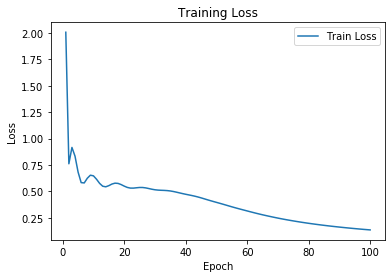

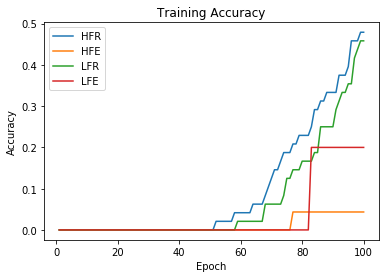

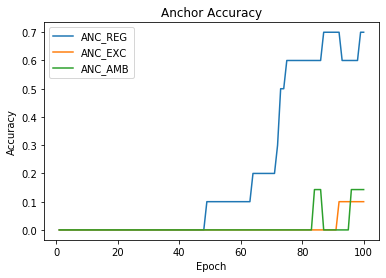

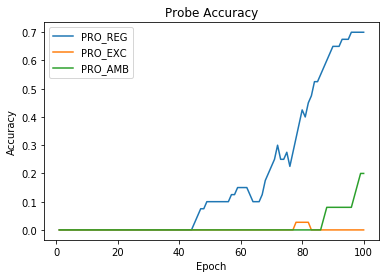

[EPOCH 101] loss: 0.134247
[EPOCH 102] loss: 0.132026
[EPOCH 103] loss: 0.129870
[EPOCH 104] loss: 0.127776
[EPOCH 105] loss: 0.125744
[EPOCH 106] loss: 0.123772
[EPOCH 107] loss: 0.121859
[EPOCH 108] loss: 0.120003
[EPOCH 109] loss: 0.118200
[EPOCH 110] loss: 0.116448
[EPOCH 111] loss: 0.114746
[EPOCH 112] loss: 0.113092
[EPOCH 113] loss: 0.111485
[EPOCH 114] loss: 0.109923
[EPOCH 115] loss: 0.108404
[EPOCH 116] loss: 0.106928
[EPOCH 117] loss: 0.105493
[EPOCH 118] loss: 0.104098
[EPOCH 119] loss: 0.102743
[EPOCH 120] loss: 0.101427
[EPOCH 121] loss: 0.100148
[EPOCH 122] loss: 0.098906
[EPOCH 123] loss: 0.097698
[EPOCH 124] loss: 0.096523
[EPOCH 125] loss: 0.095381
[EPOCH 126] loss: 0.094269
[EPOCH 127] loss: 0.093187
[EPOCH 128] loss: 0.092134
[EPOCH 129] loss: 0.091108
[EPOCH 130] loss: 0.090107
[EPOCH 131] loss: 0.089132
[EPOCH 132] loss: 0.088181
[EPOCH 133] loss: 0.087253
[EPOCH 134] loss: 0.086348
[EPOCH 135] loss: 0.085465
[EPOCH 136] loss: 0.084603
[EPOCH 137] loss: 0.083761
[

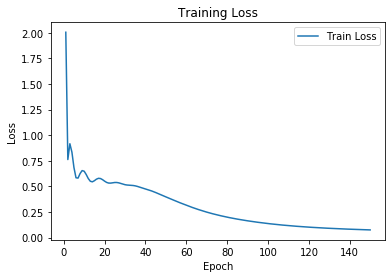

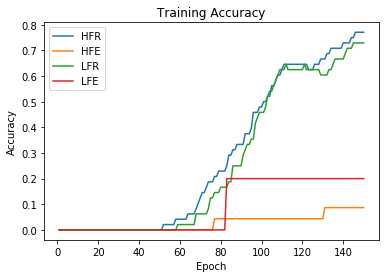

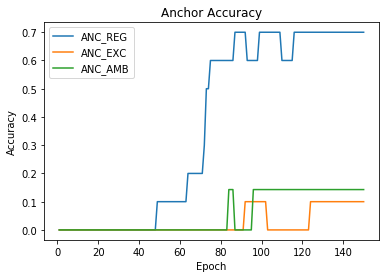

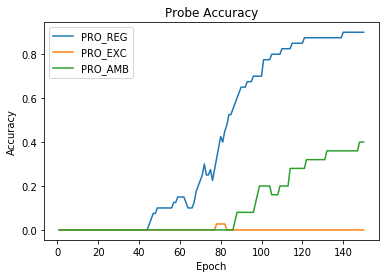

[EPOCH 151] loss: 0.073793
[EPOCH 152] loss: 0.073189
[EPOCH 153] loss: 0.072596
[EPOCH 154] loss: 0.072015
[EPOCH 155] loss: 0.071445
[EPOCH 156] loss: 0.070886
[EPOCH 157] loss: 0.070336
[EPOCH 158] loss: 0.069797
[EPOCH 159] loss: 0.069267
[EPOCH 160] loss: 0.068747
[EPOCH 161] loss: 0.068235
[EPOCH 162] loss: 0.067732
[EPOCH 163] loss: 0.067238
[EPOCH 164] loss: 0.066752
[EPOCH 165] loss: 0.066274
[EPOCH 166] loss: 0.065803
[EPOCH 167] loss: 0.065340
[EPOCH 168] loss: 0.064885
[EPOCH 169] loss: 0.064437
[EPOCH 170] loss: 0.063996
[EPOCH 171] loss: 0.063561
[EPOCH 172] loss: 0.063134
[EPOCH 173] loss: 0.062713
[EPOCH 174] loss: 0.062298
[EPOCH 175] loss: 0.061890
[EPOCH 176] loss: 0.061488
[EPOCH 177] loss: 0.061091
[EPOCH 178] loss: 0.060701
[EPOCH 179] loss: 0.060316
[EPOCH 180] loss: 0.059937
[EPOCH 181] loss: 0.059564
[EPOCH 182] loss: 0.059195
[EPOCH 183] loss: 0.058832
[EPOCH 184] loss: 0.058474
[EPOCH 185] loss: 0.058121
[EPOCH 186] loss: 0.057772
[EPOCH 187] loss: 0.057428
[

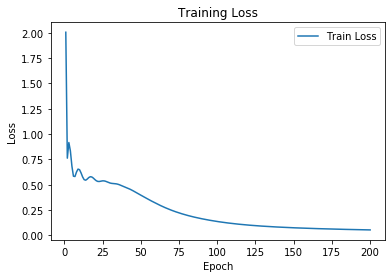

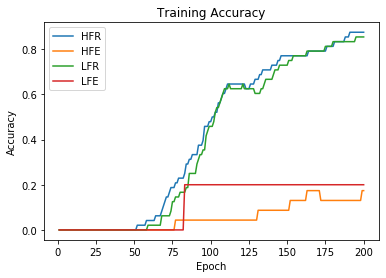

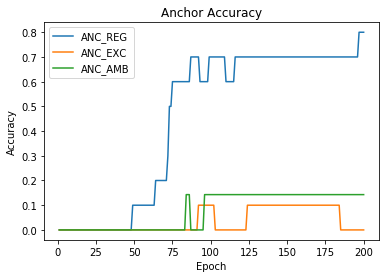

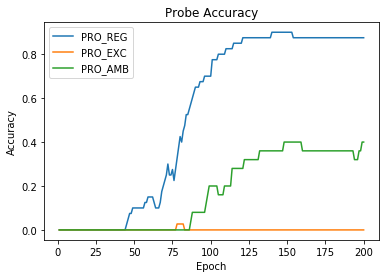

[EPOCH 201] loss: 0.053035
[EPOCH 202] loss: 0.052747
[EPOCH 203] loss: 0.052463
[EPOCH 204] loss: 0.052182
[EPOCH 205] loss: 0.051904
[EPOCH 206] loss: 0.051628
[EPOCH 207] loss: 0.051356
[EPOCH 208] loss: 0.051086
[EPOCH 209] loss: 0.050819
[EPOCH 210] loss: 0.050555
[EPOCH 211] loss: 0.050294
[EPOCH 212] loss: 0.050035
[EPOCH 213] loss: 0.049779
[EPOCH 214] loss: 0.049525
[EPOCH 215] loss: 0.049274
[EPOCH 216] loss: 0.049025
[EPOCH 217] loss: 0.048778
[EPOCH 218] loss: 0.048534
[EPOCH 219] loss: 0.048292
[EPOCH 220] loss: 0.048053
[EPOCH 221] loss: 0.047815
[EPOCH 222] loss: 0.047580
[EPOCH 223] loss: 0.047347
[EPOCH 224] loss: 0.047116
[EPOCH 225] loss: 0.046887
[EPOCH 226] loss: 0.046659
[EPOCH 227] loss: 0.046434
[EPOCH 228] loss: 0.046211
[EPOCH 229] loss: 0.045990
[EPOCH 230] loss: 0.045770
[EPOCH 231] loss: 0.045552
[EPOCH 232] loss: 0.045336
[EPOCH 233] loss: 0.045122
[EPOCH 234] loss: 0.044909
[EPOCH 235] loss: 0.044699
[EPOCH 236] loss: 0.044489
[EPOCH 237] loss: 0.044282
[

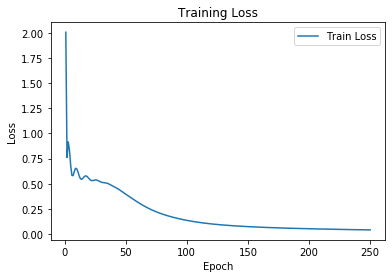

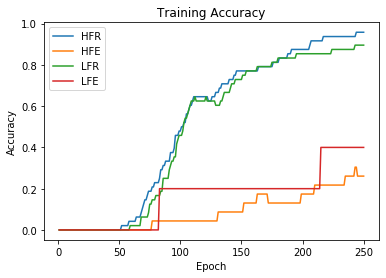

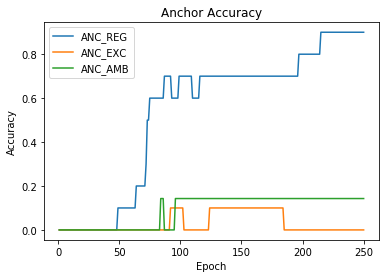

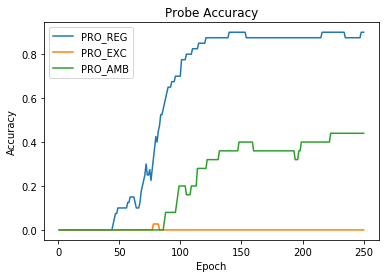

[EPOCH 251] loss: 0.041539
[EPOCH 252] loss: 0.041355
[EPOCH 253] loss: 0.041171
[EPOCH 254] loss: 0.040989
[EPOCH 255] loss: 0.040809
[EPOCH 256] loss: 0.040630
[EPOCH 257] loss: 0.040452
[EPOCH 258] loss: 0.040276
[EPOCH 259] loss: 0.040101
[EPOCH 260] loss: 0.039927
[EPOCH 261] loss: 0.039755
[EPOCH 262] loss: 0.039584
[EPOCH 263] loss: 0.039414
[EPOCH 264] loss: 0.039246
[EPOCH 265] loss: 0.039078
[EPOCH 266] loss: 0.038912
[EPOCH 267] loss: 0.038747
[EPOCH 268] loss: 0.038583
[EPOCH 269] loss: 0.038420
[EPOCH 270] loss: 0.038258
[EPOCH 271] loss: 0.038098
[EPOCH 272] loss: 0.037938
[EPOCH 273] loss: 0.037780
[EPOCH 274] loss: 0.037622
[EPOCH 275] loss: 0.037465
[EPOCH 276] loss: 0.037310
[EPOCH 277] loss: 0.037155
[EPOCH 278] loss: 0.037002
[EPOCH 279] loss: 0.036849
[EPOCH 280] loss: 0.036697
[EPOCH 281] loss: 0.036546
[EPOCH 282] loss: 0.036397
[EPOCH 283] loss: 0.036248
[EPOCH 284] loss: 0.036100
[EPOCH 285] loss: 0.035953
[EPOCH 286] loss: 0.035807
[EPOCH 287] loss: 0.035662
[

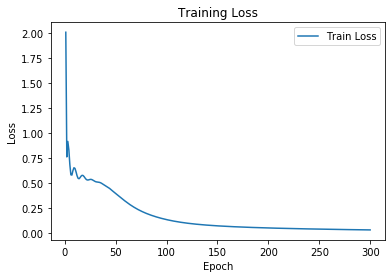

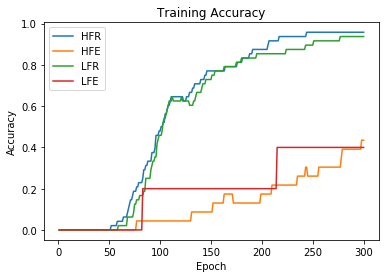

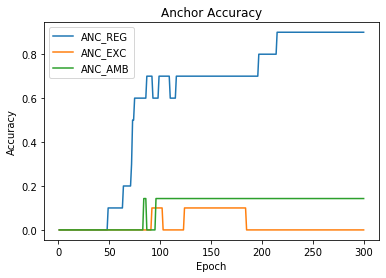

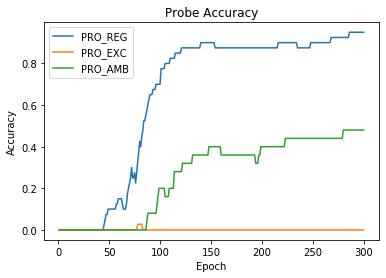

[EPOCH 301] loss: 0.033720
[EPOCH 302] loss: 0.033587
[EPOCH 303] loss: 0.033455
[EPOCH 304] loss: 0.033324
[EPOCH 305] loss: 0.033194
[EPOCH 306] loss: 0.033064
[EPOCH 307] loss: 0.032935
[EPOCH 308] loss: 0.032806
[EPOCH 309] loss: 0.032679
[EPOCH 310] loss: 0.032552
[EPOCH 311] loss: 0.032425
[EPOCH 312] loss: 0.032299
[EPOCH 313] loss: 0.032174
[EPOCH 314] loss: 0.032050
[EPOCH 315] loss: 0.031926
[EPOCH 316] loss: 0.031803
[EPOCH 317] loss: 0.031680
[EPOCH 318] loss: 0.031558
[EPOCH 319] loss: 0.031437
[EPOCH 320] loss: 0.031316
[EPOCH 321] loss: 0.031196
[EPOCH 322] loss: 0.031077
[EPOCH 323] loss: 0.030958
[EPOCH 324] loss: 0.030840
[EPOCH 325] loss: 0.030722
[EPOCH 326] loss: 0.030605
[EPOCH 327] loss: 0.030489
[EPOCH 328] loss: 0.030374
[EPOCH 329] loss: 0.030259
[EPOCH 330] loss: 0.030145
[EPOCH 331] loss: 0.030032
[EPOCH 332] loss: 0.029919
[EPOCH 333] loss: 0.029806
[EPOCH 334] loss: 0.029695
[EPOCH 335] loss: 0.029584
[EPOCH 336] loss: 0.029474
[EPOCH 337] loss: 0.029364
[

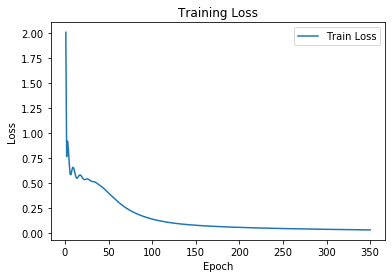

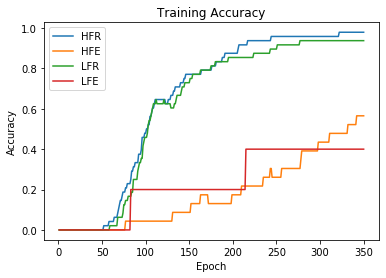

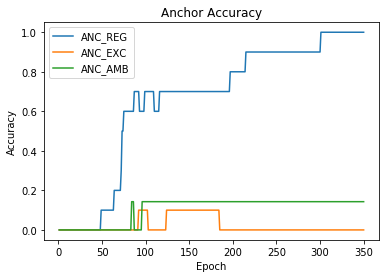

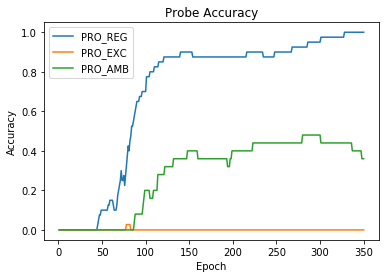

[EPOCH 351] loss: 0.027890
[EPOCH 352] loss: 0.027789
[EPOCH 353] loss: 0.027688
[EPOCH 354] loss: 0.027588
[EPOCH 355] loss: 0.027488
[EPOCH 356] loss: 0.027389
[EPOCH 357] loss: 0.027291
[EPOCH 358] loss: 0.027193
[EPOCH 359] loss: 0.027096
[EPOCH 360] loss: 0.026999
[EPOCH 361] loss: 0.026902
[EPOCH 362] loss: 0.026806
[EPOCH 363] loss: 0.026711
[EPOCH 364] loss: 0.026616
[EPOCH 365] loss: 0.026522
[EPOCH 366] loss: 0.026428
[EPOCH 367] loss: 0.026335
[EPOCH 368] loss: 0.026242
[EPOCH 369] loss: 0.026149
[EPOCH 370] loss: 0.026057
[EPOCH 371] loss: 0.025966
[EPOCH 372] loss: 0.025875
[EPOCH 373] loss: 0.025784
[EPOCH 374] loss: 0.025694
[EPOCH 375] loss: 0.025605
[EPOCH 376] loss: 0.025516
[EPOCH 377] loss: 0.025427
[EPOCH 378] loss: 0.025339
[EPOCH 379] loss: 0.025251
[EPOCH 380] loss: 0.025164
[EPOCH 381] loss: 0.025077
[EPOCH 382] loss: 0.024991
[EPOCH 383] loss: 0.024905
[EPOCH 384] loss: 0.024819
[EPOCH 385] loss: 0.024734
[EPOCH 386] loss: 0.024650
[EPOCH 387] loss: 0.024565
[

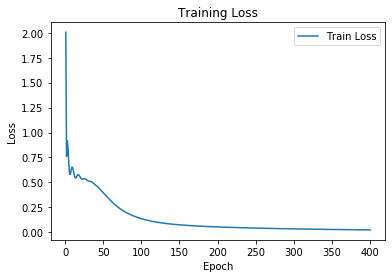

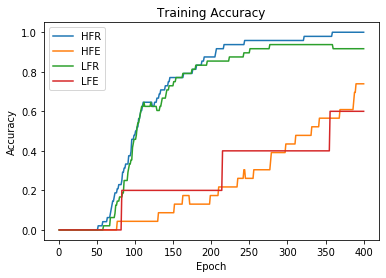

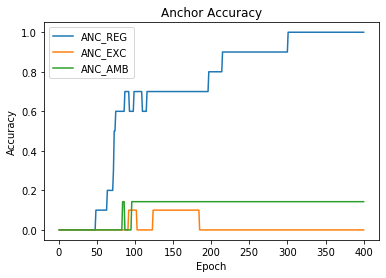

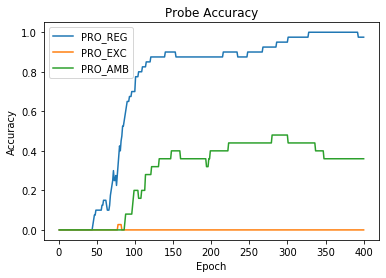

[EPOCH 401] loss: 0.023429
[EPOCH 402] loss: 0.023351
[EPOCH 403] loss: 0.023273
[EPOCH 404] loss: 0.023196
[EPOCH 405] loss: 0.023119
[EPOCH 406] loss: 0.023042
[EPOCH 407] loss: 0.022966
[EPOCH 408] loss: 0.022889
[EPOCH 409] loss: 0.022814
[EPOCH 410] loss: 0.022738
[EPOCH 411] loss: 0.022663
[EPOCH 412] loss: 0.022589
[EPOCH 413] loss: 0.022514
[EPOCH 414] loss: 0.022440
[EPOCH 415] loss: 0.022367
[EPOCH 416] loss: 0.022293
[EPOCH 417] loss: 0.022220
[EPOCH 418] loss: 0.022147
[EPOCH 419] loss: 0.022075
[EPOCH 420] loss: 0.022003
[EPOCH 421] loss: 0.021931
[EPOCH 422] loss: 0.021860
[EPOCH 423] loss: 0.021789
[EPOCH 424] loss: 0.021718
[EPOCH 425] loss: 0.021647
[EPOCH 426] loss: 0.021577
[EPOCH 427] loss: 0.021507
[EPOCH 428] loss: 0.021438
[EPOCH 429] loss: 0.021368
[EPOCH 430] loss: 0.021299
[EPOCH 431] loss: 0.021230
[EPOCH 432] loss: 0.021162
[EPOCH 433] loss: 0.021094
[EPOCH 434] loss: 0.021026
[EPOCH 435] loss: 0.020958
[EPOCH 436] loss: 0.020891
[EPOCH 437] loss: 0.020824
[

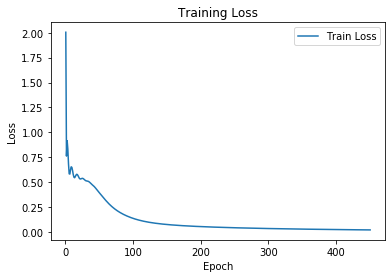

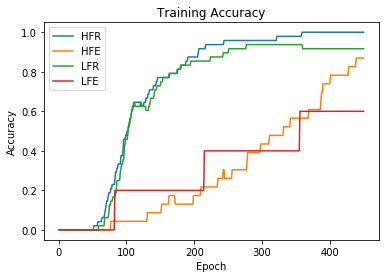

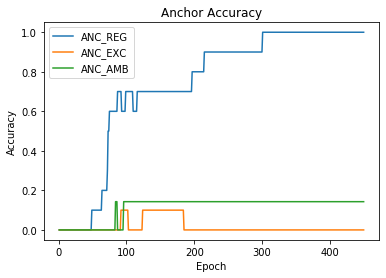

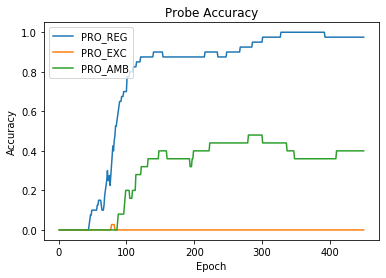

[EPOCH 451] loss: 0.019916
[EPOCH 452] loss: 0.019853
[EPOCH 453] loss: 0.019790
[EPOCH 454] loss: 0.019728
[EPOCH 455] loss: 0.019666
[EPOCH 456] loss: 0.019604
[EPOCH 457] loss: 0.019543
[EPOCH 458] loss: 0.019481
[EPOCH 459] loss: 0.019420
[EPOCH 460] loss: 0.019359
[EPOCH 461] loss: 0.019299
[EPOCH 462] loss: 0.019238
[EPOCH 463] loss: 0.019178
[EPOCH 464] loss: 0.019118
[EPOCH 465] loss: 0.019059
[EPOCH 466] loss: 0.018999
[EPOCH 467] loss: 0.018940
[EPOCH 468] loss: 0.018881
[EPOCH 469] loss: 0.018822
[EPOCH 470] loss: 0.018764
[EPOCH 471] loss: 0.018706
[EPOCH 472] loss: 0.018647
[EPOCH 473] loss: 0.018589
[EPOCH 474] loss: 0.018532
[EPOCH 475] loss: 0.018474
[EPOCH 476] loss: 0.018417
[EPOCH 477] loss: 0.018360
[EPOCH 478] loss: 0.018303
[EPOCH 479] loss: 0.018246
[EPOCH 480] loss: 0.018190
[EPOCH 481] loss: 0.018133
[EPOCH 482] loss: 0.018077
[EPOCH 483] loss: 0.018021
[EPOCH 484] loss: 0.017965
[EPOCH 485] loss: 0.017910
[EPOCH 486] loss: 0.017854
[EPOCH 487] loss: 0.017799
[

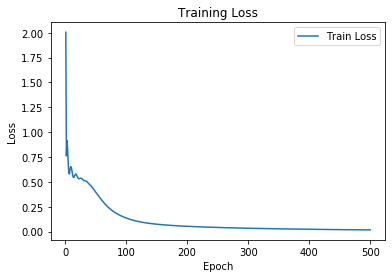

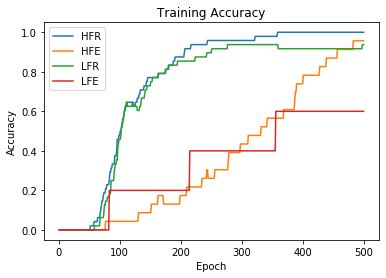

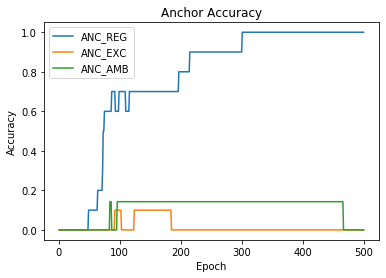

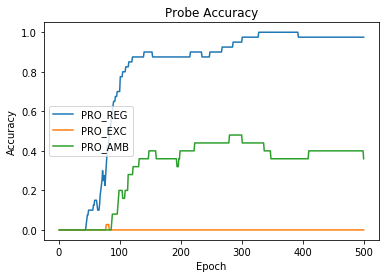

[EPOCH 501] loss: 0.007078
[EPOCH 502] loss: 0.007042
[EPOCH 503] loss: 0.006987
[EPOCH 504] loss: 0.006917
[EPOCH 505] loss: 0.006838
[EPOCH 506] loss: 0.006751
[EPOCH 507] loss: 0.006663
[EPOCH 508] loss: 0.006575
[EPOCH 509] loss: 0.006491
[EPOCH 510] loss: 0.006411
[EPOCH 511] loss: 0.006337
[EPOCH 512] loss: 0.006268
[EPOCH 513] loss: 0.006206
[EPOCH 514] loss: 0.006150
[EPOCH 515] loss: 0.006099
[EPOCH 516] loss: 0.006051
[EPOCH 517] loss: 0.006006
[EPOCH 518] loss: 0.005962
[EPOCH 519] loss: 0.005920
[EPOCH 520] loss: 0.005881
[EPOCH 521] loss: 0.005843
[EPOCH 522] loss: 0.005809
[EPOCH 523] loss: 0.005776
[EPOCH 524] loss: 0.005746
[EPOCH 525] loss: 0.005717
[EPOCH 526] loss: 0.005689
[EPOCH 527] loss: 0.005662
[EPOCH 528] loss: 0.005636
[EPOCH 529] loss: 0.005611
[EPOCH 530] loss: 0.005587
[EPOCH 531] loss: 0.005564
[EPOCH 532] loss: 0.005542
[EPOCH 533] loss: 0.005521
[EPOCH 534] loss: 0.005500
[EPOCH 535] loss: 0.005481
[EPOCH 536] loss: 0.005462
[EPOCH 537] loss: 0.005444
[

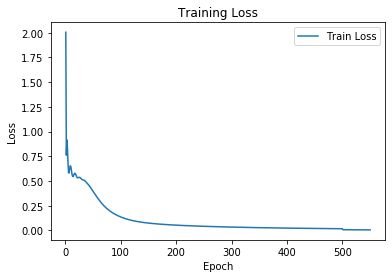

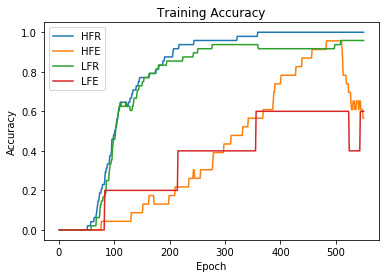

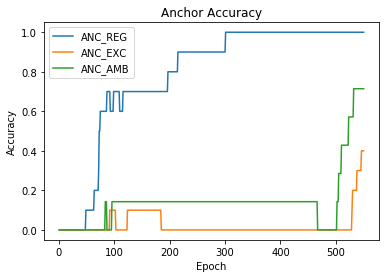

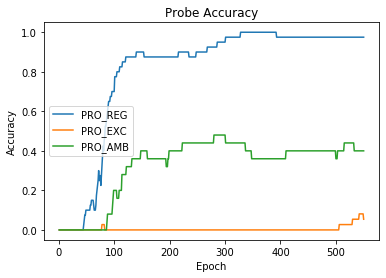

[EPOCH 551] loss: 0.005245
[EPOCH 552] loss: 0.005233
[EPOCH 553] loss: 0.005222
[EPOCH 554] loss: 0.005211
[EPOCH 555] loss: 0.005200
[EPOCH 556] loss: 0.005189
[EPOCH 557] loss: 0.005179
[EPOCH 558] loss: 0.005169
[EPOCH 559] loss: 0.005158
[EPOCH 560] loss: 0.005148
[EPOCH 561] loss: 0.005139
[EPOCH 562] loss: 0.005129
[EPOCH 563] loss: 0.005120
[EPOCH 564] loss: 0.005110
[EPOCH 565] loss: 0.005101
[EPOCH 566] loss: 0.005092
[EPOCH 567] loss: 0.005083
[EPOCH 568] loss: 0.005074
[EPOCH 569] loss: 0.005065
[EPOCH 570] loss: 0.005056
[EPOCH 571] loss: 0.005048
[EPOCH 572] loss: 0.005039
[EPOCH 573] loss: 0.005031
[EPOCH 574] loss: 0.005023
[EPOCH 575] loss: 0.005015
[EPOCH 576] loss: 0.005007
[EPOCH 577] loss: 0.004999
[EPOCH 578] loss: 0.004991
[EPOCH 579] loss: 0.004983
[EPOCH 580] loss: 0.004975
[EPOCH 581] loss: 0.004967
[EPOCH 582] loss: 0.004960
[EPOCH 583] loss: 0.004952
[EPOCH 584] loss: 0.004945
[EPOCH 585] loss: 0.004937
[EPOCH 586] loss: 0.004930
[EPOCH 587] loss: 0.004922
[

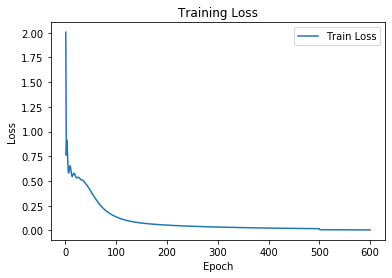

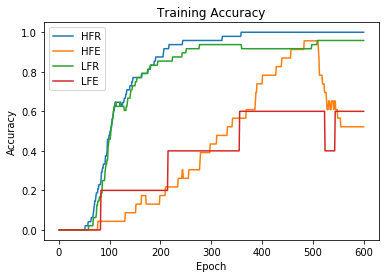

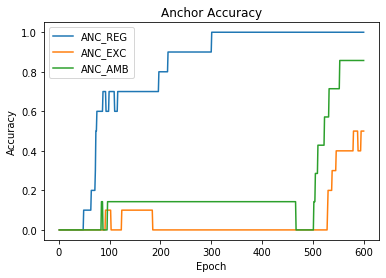

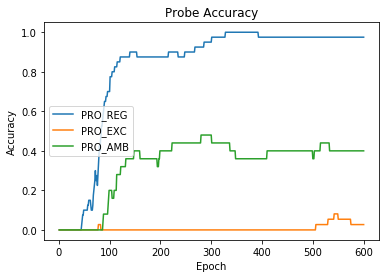

FileNotFoundError: [Errno 2] No such file or directory: '../test//Users/BrianLam/UTSC Research/Plaut_Model/results/jan01_test01/lossplot_final.png'

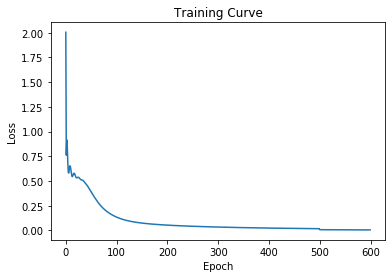

In [20]:
# create a new folder for every run
path = Path(os.getcwd()).parent #get parent (Plaut_Model) directory filepath
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = str(path)+"/results/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1


print("Test Results saved in :", rootdir)

torch.manual_seed(1) # initialize random seed
model = plaut_net() # initialize model
train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, rootdir, lr=0.1) # train!!!!

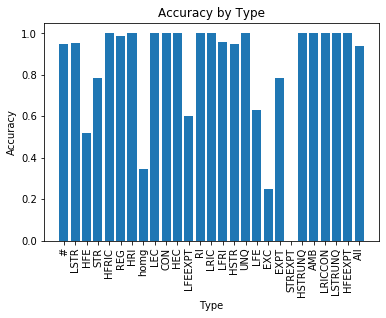

In [7]:
# obtain list of categories in dataset, and add "All" for overall accuracy
types = list(plaut_ds.df["type"].unique())
types.append("All")
    
accuracy = get_accuracy(model, plaut_loader, types)


# plot in bar graph
plt.bar(types, accuracy)
plt.xticks(rotation='vertical')
plt.xlabel("Type")
plt.ylabel("Accuracy")
plt.title("Accuracy by Type")
plt.savefig("../test/"+rootdir+"/accuracy_chart_final.png", dpi=150)
plt.show()


In [8]:
# function to get the accuracy of a particular category
def get_accuracy2 (model, train_loader, cat='All'):
    correct = 0
    total = 0
    for i, data in enumerate (train_loader): # get batch from dataloader
        # extract inputs, labels, type from batch
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        types = pd.DataFrame(data["type"])
        
        outputs = model(inputs) # find prediction using model
        outputs = outputs.round() # round output to 0 or 1
        compare = torch.eq(outputs, labels).sum(dim=1) # compare with labels
        
        if cat == 'All':
            correct += torch.eq(compare, 61).sum().item() # count as correct if all 61 elements match label
            total += len(compare)
        else:
            types = types.apply(lambda x: x == cat) # check for desired type
            compare = pd.DataFrame(compare)
            correct += ((types == True) & (compare == 61)).sum()[0] # count as correct if desired type AND all 61 elements match total
            total += (types==True).sum()[0] # count all of the desired type
    
    return correct/(total) # return accuracy

In [9]:
def get_accuracy_vowels (model, train_loader, cat=['REG', 'EXC', 'AMB']):
    correct = [0, 0, 0]
    total = [0, 0, 0]
    for i, data in enumerate (train_loader):
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        labels = labels[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        
        outputs = model(inputs)
        outputs = outputs[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        outputs = torch.sigmoid(outputs).round()
        compare = torch.eq(outputs, labels).sum(dim=1)
        for i in range(len(cat)):
            types = pd.DataFrame(data["type"])
            #print(types)
            types = types.apply(lambda x: x == cat[i])
            #print(types)
            #break
            compare = pd.DataFrame(compare)
            correct[i] += ((types == True) & (compare == len(phoneme_vowel))).sum()[0]
            total[i] += (types==True).sum()[0]
    return correct, total